## Dependencies and starter code

In [63]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import random

# Study data files
mouse_metadata_fn = "../data/Mouse_metadata.csv"
study_results_fn = "../data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_fn)
study_results = pd.read_csv(study_results_fn)

# Combine the data into a single dataset
mouse_study = pd.merge(mouse_metadata, study_results)

## Generate a summary statistics table consisting of the mean, median, variance, standard deviation, and SEM of the tumor volume for each drug regimen.

In [64]:
# Generate a summary statistics table of mean, median, variance, standard deviation, 
# and SEM of the tumor volume for each regimen
summary = pd \
    .pivot_table(
        mouse_study, 
        index="Drug Regimen", 
        values="Tumor Volume (mm3)", 
        aggfunc=["mean", "median", np.var, np.std, st.sem, "count"]) \
    .droplevel(1,1)

# Display
summary.iloc[:, 0:5].rename(columns={"mean":"Mean","median":"Median","var":"Variance","std":"Std Dev","sem":"Std Err"}) \
    .style.set_precision(2).set_caption("Total Volume By Drug")

C:\Users\norma\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\norma\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\norma\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Mean,Median,Variance,Std Dev,Std Err
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.85,42.35,6.51,0.51
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


## Bar plots
### Generate a bar plot using both Pandas's `DataFrame.plot()` and Matplotlib's `pyplot` that shows the number of data points for each treatment regimen.

<Figure size 432x288 with 0 Axes>

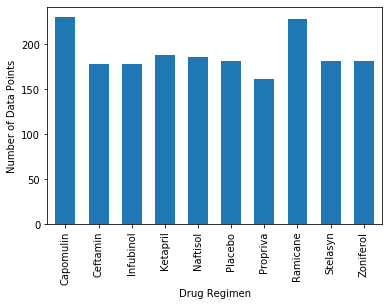

In [65]:
# Generate a bar plot showing number of data points for each treatment regimen using pandas
fig1=plt.figure(1)
summary.plot.bar(y="count",legend=False, width=0.6)
plt.ylabel("Number of Data Points")
plt.show()

In [66]:
plt.close(fig1)

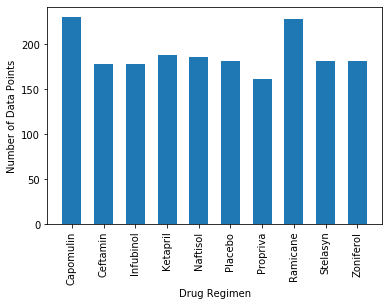

In [67]:
# Generate a bar plot showing number of data points for each treatment regimen using pyplot
fig2 = plt.figure(2)
plt.bar(x=summary.index, height=summary["count"], width=0.6)
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Data Points")
plt.xticks(rotation=90)
plt.show()

In [68]:
plt.close(fig2)

## Pie plots
### Generate a pie plot using both Pandas's `DataFrame.plot()` and Matplotlib's `pyplot` that shows the distribution of female or male mice in the study.

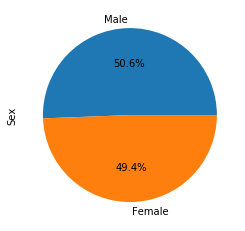

In [69]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
fig3 = plt.figure(3)
mouse_study.Sex.value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

In [70]:
plt.close(fig3)

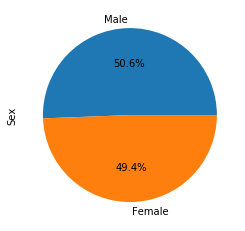

In [71]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
fig4 = plt.figure(4)
sex_counts = mouse_study.Sex.value_counts()
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%')
plt.ylabel("Sex")
plt.show()

In [72]:
plt.close(fig4)

## Quartiles, outliers and boxplots
### Calculate the final tumor volume of each mouse across four of the most promising treatment regimens: Capomulin, Ramicane, Infubinol, and Ceftamin. Calculate the quartiles and IQR and quantitatively determine if there are any potential outliers across all four treatment regimens.

In [73]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. 
# I interpreted the "final" tumor volume to mean when Timepoint = 45, which was the common terminal Timepoint.
promising_regimens = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]
full_four = mouse_study[(mouse_study.Timepoint==45) 
                        & (mouse_study["Drug Regimen"].isin(promising_regimens))]

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# First, compute the quartile boundaries for each promising regimen
# I am also curious to see the min and max values, so I am including q = 0 and q = 1
quartiles = full_four.groupby("Drug Regimen").apply(pd.DataFrame.quantile, q=np.arange(0.0,1.25,0.25))["Tumor Volume (mm3)"]

# Reshape the quartiles
quartiles_as_columns = quartiles \
    .reset_index() \
    .rename(columns={"level_1":"Quartile"}) \
    .pivot(index='Drug Regimen', columns='Quartile', values='Tumor Volume (mm3)') \
    .reset_index()
# Add computed columns for IQR, and Outlier Boundaries
quartiles_as_columns["IQR"] = quartiles_as_columns[0.75] - quartiles_as_columns[0.25]
quartiles_as_columns["Outlier Low Wall"] = quartiles_as_columns[0.25] - 1.5 * quartiles_as_columns["IQR"]
quartiles_as_columns["Outlier High Wall"] = quartiles_as_columns[0.75] + 1.5 * quartiles_as_columns["IQR"]

# Combine the data with the quartiles
full_four = full_four.merge(quartiles_as_columns)

# Search for outliers
outliers = full_four[(full_four["Tumor Volume (mm3)"] < full_four["Outlier Low Wall"]) 
                     | (full_four["Tumor Volume (mm3)"] > full_four["Outlier High Wall"])]
outliers
# My approach identified no outliers

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,0.0,0.25,0.5,0.75,1.0,IQR,Outlier Low Wall,Outlier High Wall


* No outliers were found using my approach.

## Using Matplotlib, generate a box and whisker plot of the final tumor volume for all four treatment regimens and highlight any potential outliers in the plot by changing their color and style.
  **Hint**: All four box plots should be within the same figure
        * I tried two approaches to put the four whisker plots into one figure.

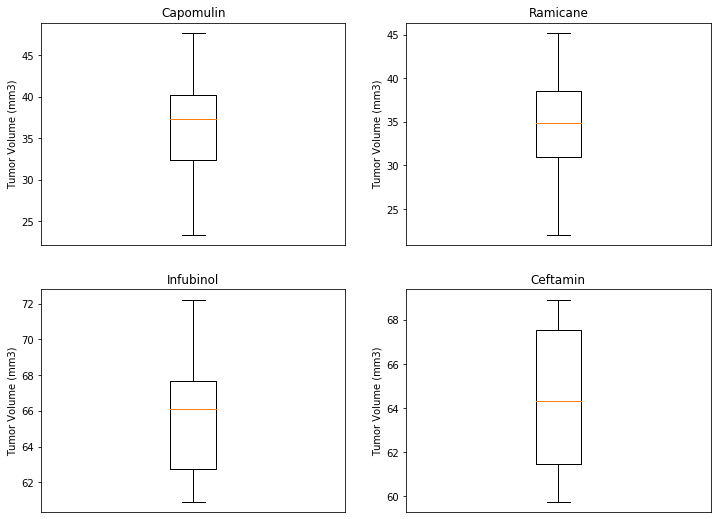

In [85]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
fig5 = plt.figure(5, figsize=[12, 9])
for row in range(len(promising_regimens)):
    regimen = promising_regimens[row]
    plt.subplot(2,2,row+1)
    plt.boxplot(full_four[full_four["Drug Regimen"] == regimen]["Tumor Volume (mm3)"])
    ax1 = plt.gca()
    ax1.axes.tick_params(axis='x',length=0,labelbottom=False)
    plt.ylabel("Tumor Volume (mm3)")
    plt.title(regimen)

In [75]:
plt.close(fig5)

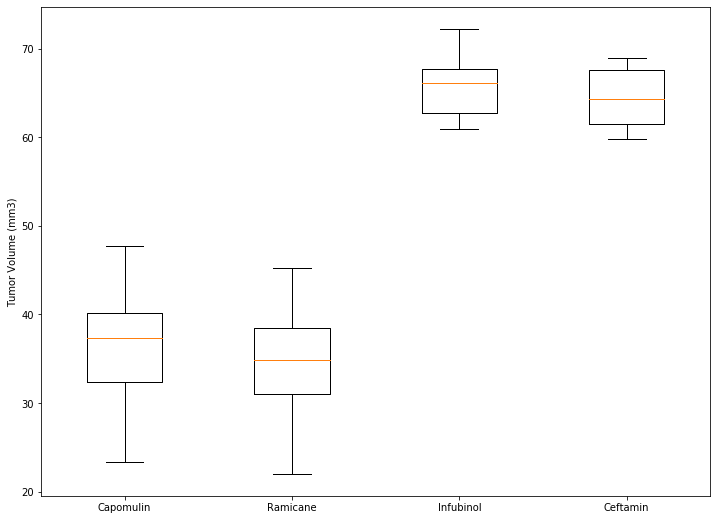

In [87]:
# Create a list of DataFrames (or Series)
four_distinct2 = [full_four[full_four["Drug Regimen"] == regimen]["Tumor Volume (mm3)"].rename(regimen) 
                  for regimen in promising_regimens]
fig6 = plt.figure(6, figsize=[12, 9])
plt.boxplot(four_distinct2, labels=promising_regimens)
plt.ylabel("Tumor Volume (mm3)")
plt.show()

In [77]:
plt.close(fig6)

## Line Plot

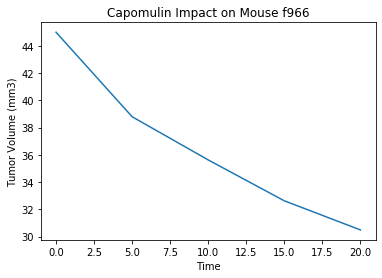

In [78]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
capomulin_study = mouse_study[mouse_study["Drug Regimen"]=="Capomulin"]
mouse = mouse_study[mouse_study["Mouse ID"] == random.choice(capomulin_study["Mouse ID"].unique())]
fig7 = plt.figure(7)
plt.plot(mouse.Timepoint, mouse["Tumor Volume (mm3)"])
plt.xlabel("Time")
plt.ylabel("Tumor Volume (mm3)")
plt.title("Capomulin Impact on Mouse " + mouse["Mouse ID"].iloc[0])
plt.show()


## Scatter plot

In [79]:
plt.close(fig7)

In [80]:
# Create a DataFrame of weight and tumor volume for Capomulin mice
weight_and_volume = pd.pivot_table(
    capomulin_study, 
    index="Mouse ID", 
    values=["Weight (g)", "Tumor Volume (mm3)"], 
    aggfunc="mean")

In [84]:
# Calculate the correlation coefficient and linear regression model for mouse weight 
# and average tumor volume for the Capomulin regimen
corr,_ = st.pearsonr(weight_and_volume["Weight (g)"], weight_and_volume["Tumor Volume (mm3)"])
print(f"The correlation between mouse weight and tumor volume is {corr:.2f}.")

The correlation between mouse weight and tumor volume is 0.84.


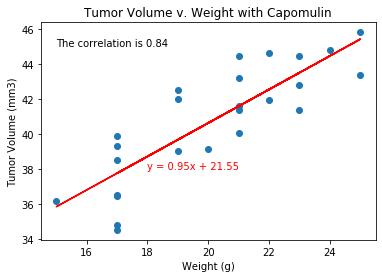

In [81]:
# Add the linear regression equation and line to plot
x_values = weight_and_volume["Weight (g)"]
y_values = weight_and_volume["Tumor Volume (mm3)"]
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot
fig8 = plt.figure(8)
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(18,38),color="red")
plt.annotate(f"The correlation is {corr:.2f}",(15,45))
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
plt.title("Tumor Volume v. Weight with Capomulin")
plt.show()

In [82]:
plt.close(fig8)

## Observations and Insights
* Of the mice treated with Capomulin, tumor volume was strongly correlated with mice weight.
* Capomulin had the second-smallest average tumor volumes in this study.
* With more time and energy, I would study "tumor volume % reduction" as a comparative criteria.
* Capomulin was not effective for all mice.
* Capomulin may cause whisker loss, diarrhea, constipation, loss of appetite, insomnia, and tail shortening.  Consult your veterinarian before taking.